In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt


## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Convolution1D,Dropout,MaxPooling1D,Conv1D,Input,Flatten
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [3]:
import os


## Loading & Exploring dataset

In [4]:
tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')



In [5]:
print('training data shape', tweet.shape)
print('test data shape', test.shape)

training data shape (7613, 5)
test data shape (3263, 4)


In [6]:
def explore_data(df):
    
    '''Input- df= pandas dataframes to be explored
       Output- print shape, info and first 5 records of the dataframe 
    '''
    
    print("-"*50)
    print('Shape of the dataframe:',df.shape)
    print("Number of records in train data set:",df.shape[0])
    print("Information of the dataset:")
    df.info()
    print("-"*50)
    print("First 5 records of the dataset:")
    return df.head()
    print("-"*50)

In [7]:
# Lets use explore_data() function to explore train data
explore_data(tweet)

--------------------------------------------------
Shape of the dataframe: (7613, 5)
Number of records in train data set: 7613
Information of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
--------------------------------------------------
First 5 records of the dataset:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Lets use explore_data() function to explore test data
explore_data(test)

--------------------------------------------------
Shape of the dataframe: (3263, 4)
Number of records in train data set: 3263
Information of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
--------------------------------------------------
First 5 records of the dataset:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Class Distribution

Target of 0 is 57.0 % of total
Target of 1 is 43.0 % of total


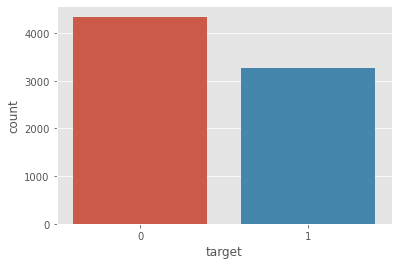

In [9]:

feature='target'
sns.countplot(feature, data=tweet)
print('Target of 0 is {} % of total'.format(round(tweet[feature].value_counts()[0]/len(tweet[feature])*100)))
print('Target of 1 is {} % of total'.format(round(tweet[feature].value_counts()[1]/len(tweet[feature])*100)))


## Data Pre-processing

Before starting any NLP project, text data needs to be pre-processed to convert it into in a consistent format.Text will be cleaned, tokneized and converted into a matrix.

Some of the basic text pre-processing techniques includes:
1. **Make text all lower or uppercase**
2. **Removing Noise** - Remove Punctuation and numerical Values
3. **Tokenization**  - Process of converting the normal text strings into a list of tokens i.e. words.
4. **Stopword Removal**-Some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely.
5. **Stemming**-Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
6. **Lemmatization**-A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.




### Data Cleaning

In [10]:
#Create a function to clean the text
def clean_text(text):

    '''
    Input- 'text' to be cleaned
       
       Output- Convert input 'text' to lowercase,remove square brackets,links,punctuation
       and words containing numbers. Return clean text.
    
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
tweet_df1=tweet.copy()
test_df1=test.copy()
tweet_df1['text'] = tweet_df1['text'].apply(lambda x: clean_text(x))
test_df1['text'] = test_df1['text'].apply(lambda x: clean_text(x))

In [12]:
#Lets look at cleaned data
def text_after_preprocess(before_text,after_text):
    
    '''
    Input- before_text=text column before cleanup
              after_text= text column after cleanup
       Output- print before and after text to compare how it looks after cleanup
       
    '''
    print('-'*60)
    print('Text before cleanup')
    print('-'*60)
    print(before_text.head(5))
    print('-'*60)
    print('Text after cleanup')
    print('-'*60)
    print(after_text.head(5))

In [13]:
text_after_preprocess(tweet.text,tweet_df1.text)


------------------------------------------------------------
Text before cleanup
------------------------------------------------------------
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
------------------------------------------------------------
Text after cleanup
------------------------------------------------------------
0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object


In [14]:
text_after_preprocess(test.text,test_df1.text)


------------------------------------------------------------
Text before cleanup
------------------------------------------------------------
0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object
------------------------------------------------------------
Text after cleanup
------------------------------------------------------------
0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object


### Tokenization

In [15]:
import nltk
# Example how tokenization of text works
text = "Heard about #earthquake is different cities, stay safe everyone."
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')
print("-"*100)
print("Example Text: ",text)
print("-"*100)
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

----------------------------------------------------------------------------------------------------
Example Text:  Heard about #earthquake is different cities, stay safe everyone.
----------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Heard', 'about', '#earthquake', 'is', 'different', 'cities,', 'stay', 'safe', 'everyone.']
Tokenization by words using Treebank Word Tokenizer:-  ['Heard', 'about', '#', 'earthquake', 'is', 'different', 'cities', ',', 'stay', 'safe', 'everyone', '.']
Tokenization by punctuation:-  ['Heard', 'about', '#', 'earthquake', 'is', 'different', 'cities', ',', 'stay', 'safe', 'everyone', '.']
Tokenization by regular expression:-  ['Heard', 'about', 'earthquake', 'is', 'different', 'cities', 'stay', 'safe', 'everyone']


In [16]:
#before tokenization
tweet_df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [17]:
# Lets Tokenize the training and the test dataset copies with RegEx tokenizer
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tweet_df1['text'] = tweet_df1['text'].apply(lambda x: tokenizer.tokenize(x))
test_df1['text'] = test_df1['text'].apply(lambda x: tokenizer.tokenize(x))

In [18]:
#lets check tokenized text
tweet_df1['text']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [people, receive, wildfires, evacuation, order...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610                             [s, of, volcano, hawaii]
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: text, Length: 7613, dtype: object

### Stop words Removal

In [19]:
#Create a funtion to remove stopwords
def remove_stopwords(text):
    
    """
    Input- text=text from which english stopwprds will be removed
    Output- return text without english stopwords 
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words



In [20]:
#Before stopwords removal
tweet_df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, earth...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[all, residents, asked, to, shelter, in, place...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[just, got, sent, this, photo, from, ruby, ala...",1


In [21]:
tweet_df1['text'] = tweet_df1['text'].apply(lambda x : remove_stopwords(x))
test_df1['text'] = test_df1['text'].apply(lambda x : remove_stopwords(x))

In [22]:
#after stopwords removal
tweet_df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


## Stemming and Lemmatization

Stemming and lemmatization sometimes doesnt necessarily improve results as sometimes we dont want to trim words rather preserve their original form.Its usage from problem to problem and for this problem it wouldnt be good idea to use it.

In [23]:
# Stemming and Lemmatization examples
text =  [ 'deduced', 'dogs', 'talking', 'studies']
def Stemming_Lemmatizing(text):
    # Lemmatizer
    lemmatizer=nltk.stem.WordNetLemmatizer()
    words=[lemmatizer.lemmatize(token) for token in text]
    
    # Stemmer
    stemmer = nltk.stem.PorterStemmer()
    words=[stemmer.stem(token) for token in text]

    return words

In [24]:
Stemming_Lemmatizing(text)

['deduc', 'dog', 'talk', 'studi']

In [25]:
#tweet_df1['text'] = tweet_df1['text'].apply(lambda x : Stemming_Lemmatizing(x))
#test_df1['text'] = test_df1['text'].apply(lambda x : Stemming_Lemmatizing(x))

### Convert the text list into string

In [26]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 
        
        
# Driver code     
s = ['Geeks', 'for', 'Geeks'] 
print(listToString(s))  

Geeks for Geeks


In [27]:
#tweet_df1['text'] = tweet_df1['text'].apply(lambda x : listToString(x))
#test_df1['text'] = test_df1['text'].apply(lambda x : listToString(x))

### Spell Checker

In [28]:
!pip install pyspellchecker


     |████████████████████████████████| 1.9 MB 2.9 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [29]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [30]:
tweet_df1['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                                    [volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [31]:
df=pd.concat([tweet_df1,test_df1])
df.shape

(10876, 5)

## GloVe for Vectorization

In [32]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in tweet if((word.isalpha()==1) )]
        corpus.append(words)
    return corpus

In [33]:
corpus=create_corpus(df)


100%|██████████| 10876/10876 [00:00<00:00, 177230.08it/s]


In [34]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [35]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [36]:
tweet_pad.shape

(10876, 50)

In [37]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20680


## Create an Embedding Matrix

In [38]:
num_words=len(word_index)+1

embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20680/20680 [00:00<00:00, 234544.22it/s]


In [39]:
num_words

20681

### Initiating TPU 

In [40]:
import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Creating a Baseline Model

In [41]:
with tpu_strategy.scope():
    model=Sequential()

    embedding=Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

    model.add(embedding)
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))


    optimzer=Adam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [42]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

## Split  training and validation set

In [43]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [44]:
history=model.fit(X_train,y_train,batch_size=16,epochs=15,validation_data=(X_test,y_test),verbose=True)

Epoch 1/15
405/405 [==============================] - 8s 19ms/step - loss: 0.6921 - accuracy: 0.5715 - val_loss: 0.6914 - val_accuracy: 0.5578
Epoch 2/15
405/405 [==============================] - 6s 15ms/step - loss: 0.6854 - accuracy: 0.5726 - val_loss: 0.6591 - val_accuracy: 0.5683
Epoch 3/15
405/405 [==============================] - 6s 15ms/step - loss: 0.5895 - accuracy: 0.7130 - val_loss: 0.5358 - val_accuracy: 0.7636
Epoch 4/15
405/405 [==============================] - 6s 14ms/step - loss: 0.5464 - accuracy: 0.7493 - val_loss: 0.5160 - val_accuracy: 0.7662
Epoch 5/15
405/405 [==============================] - 6s 15ms/step - loss: 0.5309 - accuracy: 0.7560 - val_loss: 0.5046 - val_accuracy: 0.7680
Epoch 6/15
405/405 [==============================] - 6s 15ms/step - loss: 0.5181 - accuracy: 0.7603 - val_loss: 0.4971 - val_accuracy: 0.7750
Epoch 7/15
405/405 [==============================] - 6s 15ms/step - loss: 0.5106 - accuracy: 0.7668 - val_loss: 0.4919 - val_accuracy: 0.7776

In [45]:
#Creating a callback Function
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
             ReduceLROnPlateau(monitor='val_accuracy', 
                               factor=0.2, 
                               patience=3, 
                               verbose=1)]

filter_length1 = 3
filter_length2 = 5
dropout=0.5
nb_filter = 64
learning_rate=3e-3


## Adding a Cnn layer

In [46]:
with tpu_strategy.scope():
    model=Sequential()

    embedding=Embedding(input_dim=num_words,output_dim=200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

    model.add(embedding)
    model.add(SpatialDropout1D(0.2))
   
    model.add(Conv1D(filters = 64, kernel_size = 5,padding = 'same', activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))




    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate),metrics=['accuracy'])
    

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           4136200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 64)            64064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,233,353
Trainable params: 97,153
Non-trainable params: 4,136,200
_______________________________________

In [48]:
history=model.fit(X_train,y_train,batch_size=8,epochs=30,validation_data=(X_test,y_test),verbose=True,callbacks = callbacks)


Epoch 1/30
809/809 [==============================] - 12s 15ms/step - loss: 0.4953 - accuracy: 0.7742 - val_loss: 0.4650 - val_accuracy: 0.7933 - lr: 0.0030
Epoch 2/30
809/809 [==============================] - 10s 12ms/step - loss: 0.4306 - accuracy: 0.8142 - val_loss: 0.4922 - val_accuracy: 0.7872 - lr: 0.0030
Epoch 3/30
809/809 [==============================] - 11s 13ms/step - loss: 0.3917 - accuracy: 0.8371 - val_loss: 0.5135 - val_accuracy: 0.7863 - lr: 0.0030
Epoch 4/30
805/809 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8528
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006000000052154065.
809/809 [==============================] - 11s 13ms/step - loss: 0.3620 - accuracy: 0.8524 - val_loss: 0.4595 - val_accuracy: 0.7898 - lr: 0.0030
Epoch 5/30
809/809 [==============================] - 11s 13ms/step - loss: 0.2958 - accuracy: 0.8880 - val_loss: 0.5224 - val_accuracy: 0.7986 - lr: 6.0000e-04
Epoch 6/30
809/809 [==========================

In [49]:
import keras
model1 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=num_words,output_dim=200,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LEN,trainable=False),
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(200),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])


In [50]:
model1.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 200)           4136200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           120400    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 4,497,601
Trainable params: 361,401
Non-trainable params: 4,136,200
_________________________________________________________________


In [51]:
model1.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)


In [52]:
history1 = model1.fit(X_train,y_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2
)

Epoch 1/10
81/81 [==============================] - 10s 127ms/step - loss: 0.5269 - accuracy: 0.7544 - val_loss: 0.4255 - val_accuracy: 0.8162
Epoch 2/10
81/81 [==============================] - 9s 117ms/step - loss: 0.4493 - accuracy: 0.8078 - val_loss: 0.4198 - val_accuracy: 0.8309
Epoch 3/10
81/81 [==============================] - 9s 117ms/step - loss: 0.4427 - accuracy: 0.8221 - val_loss: 0.4668 - val_accuracy: 0.7668
Epoch 4/10
81/81 [==============================] - 9s 115ms/step - loss: 0.4294 - accuracy: 0.8190 - val_loss: 0.4160 - val_accuracy: 0.8147
Epoch 5/10
81/81 [==============================] - 9s 116ms/step - loss: 0.4077 - accuracy: 0.8352 - val_loss: 0.4271 - val_accuracy: 0.8201
Epoch 6/10
81/81 [==============================] - 10s 120ms/step - loss: 0.3778 - accuracy: 0.8481 - val_loss: 0.4402 - val_accuracy: 0.8201
Epoch 7/10
81/81 [==============================] - 9s 117ms/step - loss: 0.3720 - accuracy: 0.8514 - val_loss: 0.4197 - val_accuracy: 0.8247
Epoc

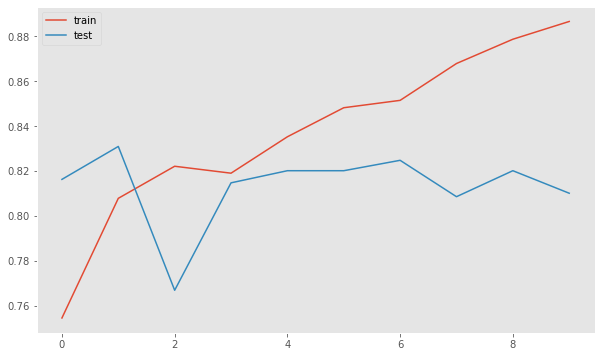

In [53]:
plt.figure(figsize=(10,6))
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.legend()
plt.grid()
plt.show()

In [54]:
model2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=num_words,output_dim=200,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LEN,trainable=False),
    keras.layers.GRU(100,return_sequences=True),
    keras.layers.GRU(200),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')
])

In [55]:
model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 200)           4136200   
_________________________________________________________________
gru (GRU)                    (None, 50, 100)           90600     
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               181200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 4,408,201
Trainable params: 272,001
Non-trainable params: 4,136,200
_________________________________________________________________


In [56]:
model2.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)


In [57]:
history2 = model2.fit(X_train,y_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.2
)

Epoch 1/10
81/81 [==============================] - 9s 109ms/step - loss: 0.6846 - accuracy: 0.5699 - val_loss: 0.6795 - val_accuracy: 0.5830
Epoch 2/10
81/81 [==============================] - 8s 98ms/step - loss: 0.6851 - accuracy: 0.5699 - val_loss: 0.6813 - val_accuracy: 0.5830
Epoch 3/10
81/81 [==============================] - 8s 99ms/step - loss: 0.6846 - accuracy: 0.5699 - val_loss: 0.6813 - val_accuracy: 0.5830
Epoch 4/10
81/81 [==============================] - 8s 99ms/step - loss: 0.6844 - accuracy: 0.5699 - val_loss: 0.6795 - val_accuracy: 0.5830
Epoch 5/10
81/81 [==============================] - 8s 100ms/step - loss: 0.6840 - accuracy: 0.5699 - val_loss: 0.6815 - val_accuracy: 0.5830
Epoch 6/10
81/81 [==============================] - 8s 102ms/step - loss: 0.6843 - accuracy: 0.5699 - val_loss: 0.6793 - val_accuracy: 0.5830
Epoch 7/10
81/81 [==============================] - 8s 98ms/step - loss: 0.6844 - accuracy: 0.5699 - val_loss: 0.6793 - val_accuracy: 0.5830
Epoch 8/10

## Making Submission

In [58]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')


In [59]:
y_pre=model.predict(test)


In [60]:
y_pre.shape

(3264, 1)